# Building a Spam Filter with Naive Bayes

#### Table of Contents

* [Introduction](#1)
* [Dataset Exploration](#2)
* [Training and Test Set](#3)
* [Data Cleaning](#4)
* [Building Vocabulary List](#5)
* [Transforming the Training Set](#6)
* [Calculating Probability Constants](#7)
* [Classifying New Messages](#8)
* [Measuring the Spam Filter's Accuracy](#9)
* [Conclusion](#10)
* [Additional](#11)

#### Introduction <a class='anchor' id='1'></a>

In this project, we're going to study the practical side of the algorithm by building a spam filter for SMS messages. To do that, we'll use the multinomial Naive Bayes algorithm along with a dataset of 5,572 SMS messages that are already classified by people. The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The UCI Machine Learning Repository or [here](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).

To create the spam filter, we will write a script that will get the computer to:
- Learn how we classify messages as spam or non-spam
- Use that information to calculate probabilities for new messages as being spam or non-spam
- Then, classify messages based on:
    - the probability for spam is greater than non-spam: Spam
    - the probability for non-spam is greater than spam: Non-spam (or ham in the case of dataset labeling)
    - the probabilities for spam and non-spam are equal: Human intervention to classify message required

#### Dataset Exploration <a class='anchor' id='2'></a>

In [39]:
#Import libraries
import pandas as pd, matplotlib.pyplot as plt
import re

#Read in csv files
spam = pd.read_csv('D:/DataQuest/SMSSpamCollection',sep='\t',header=None, names=['Label','SMS'])

In [40]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   SMS     5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [41]:
spam.head(3) #ham = not spam

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [42]:
spam.tail(3)

,Label,SMS
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [43]:
spam.isnull().sum()

Label    0
SMS      0
dtype: int64

There are no null values.

In [44]:
spam['Label'].value_counts(normalize=True)

Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

About 86% of the messages are not spam.

#### Training and Test Set <a class='anchor' id='3'></a>

Once our spam filter is done, we'll need to test how good it is with classifying new messages. 

To test the spam filter, we're first going to split our dataset into two categories:
- A training set, which we'll use to "train" the computer how to classify messages.
- A test set, which we'll use to test how good the spam filter is with classifying new messages.


We're going to keep 80% of our dataset for training, and 20% for testing (we want to train the algorithm on as much data as possible, but we also want to have enough test data). 

The dataset has 5,572 messages, which means that:
The training set will have 4,458 messages (about 80% of the dataset).
The test set will have 1,114 messages (about 20% of the dataset).

To better understand the purpose of putting a test set aside, let's begin by observing that all 1,114 messages in our test set are already classified by a human. 
When the spam filter is ready, we're going to treat these messages as new and have the filter classify them. Once we have the results, we'll be able to compare the algorithm classification with that done by a human, and this way we'll see how good the spam filter really is.

For this project, our goal is to create a spam filter that classifies new messages with an accuracy greater than 80% — so we expect that more than 80% of the new messages will be classified correctly as spam or ham (non-spam).

In [45]:
#Let's randomize the dataset first
spam_rand =spam.sample(frac=1, random_state=1)

In [46]:
#Split into training and test set (80/20), we do this by taking 80/20 of the index
take_index = round(len(spam_rand)*0.8)
training_set = spam_rand[:take_index].reset_index(drop=True)
test_set = spam_rand[take_index:].reset_index(drop=True)
print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [47]:
#Check our datasets
training_set['Label'].value_counts(normalize=True)

Label
ham     0.86541
spam    0.13459
Name: proportion, dtype: float64

In [48]:
test_set['Label'].value_counts(normalize=True)

Label
ham     0.868043
spam    0.131957
Name: proportion, dtype: float64

#### Data Cleaning <a class='anchor' id='4'></a>

To proceed further we will need to clean the data. We will do this by cleaning the SMS column. 
Remove the punctuations and make them all lowercase.

In [49]:
training_set.head(5)

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [50]:
#Standardize our SMS messages - remove punctuation and standardize to lower case
training_set['SMS'] = training_set['SMS'].str.replace(r"\W", ' ', regex=True)
training_set['SMS'] = training_set['SMS'].str.lower()
training_set['SMS'] = training_set['SMS'].str.split()
training_set['SMS']

0                       [yep, by, the, pretty, sculpture]
1       [yes, princess, are, you, going, to, make, me,...
2                         [welp, apparently, he, retired]
3                                                [havent]
4       [i, forgot, 2, ask, ü, all, smth, there, s, a,...
                              ...                        
4453    [sorry, i, ll, call, later, in, meeting, any, ...
4454    [babe, i, fucking, love, you, too, you, know, ...
4455    [u, ve, been, selected, to, stay, in, 1, of, 2...
4456    [hello, my, boytoy, geeee, i, miss, you, alrea...
4457                              [wherre, s, my, boytoy]
Name: SMS, Length: 4458, dtype: object

#### Building Vocabulary List <a class='anchor' id='5'></a>

Let's create a list with all of the unique words that occur in the messages of our training set.

This vocabulary list will be used to create all the columns of unique words for all the SMS.

In [51]:
vocabulary = []
for row in training_set['SMS']:
    vocabulary += row
vocabulary = list(set(vocabulary))
print(vocabulary)

['kisi', 'bike', 'jus', '31p', 'eppolum', 'showing', '2stoptx', 'admin', 'mega', 'solihull', 'dogg', '75max', 'posted', 'horny', 'box97n7qp', 'nudist', 'yrs', 'ha', 'canal', '37819', 'simpsons', 'till', '08718738034', 'murdered', 'dropped', 'mix', 'blood', 'lions', 'allowed', 'seeking', 'sec', '1x150p', 'domain', '26th', 'rum', '08002888812', 'nimbomsons', 'intro', 'dysentry', 'describe', 'quiteamuzing', '8007', 'accessible', 'missunderstding', 'blind', 'worry', 'bird', 'neglect', 'dying', 'dancce', '28days', 'mns', 'anniversary', 'pick', 'lies', 'sex', 'impressively', '5', 'affairs', 'setting', 'possibly', 'replace', 'nike', 'shining', 'floppy', 'fault', '09094646899', 'entitled', 'greece', 'wn', 'doubt', '6th', 'role', 'jabo', 'elections', 'extreme', 'roles', 'sleeping', 'retard', 'network', 'entry', 'supervisor', 'prefer', 'jeremiah', '600', 'xam', 'lines', 'melody', 'xxsp', 'msn', 'hop', 'izzit', 'option', 'taka', 'starwars3', 'men', 'sch', 'ec2a', 'gravel', 'weirdo', 'roomate', 's

#### Transforming the Training Set <a class='anchor' id='6'></a>

In [52]:
#Create the word dictionary - each key is a unique word and each value is the number of counts of the word appearing in the SMS message
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [53]:
#Create DataFrame
sms_word_count = pd.DataFrame(word_counts_per_sms)
sms_word_count.head()

,kisi,bike,jus,31p,eppolum,showing,2stoptx,admin,mega,solihull,...,club4,breathing,method,whats,tm,married,red,wherevr,registered,musicnews
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Concatenate the two DataFrames to include label and SMS
training_set_clean = pd.concat([training_set, sms_word_count], axis=1)
training_set_clean.head()

,Label,SMS,kisi,bike,jus,31p,eppolum,showing,2stoptx,admin,...,club4,breathing,method,whats,tm,married,red,wherevr,registered,musicnews
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
#Double check it is correct
training_set_clean[['yep','by']].head()

,yep,by
0,1,1
1,0,0
2,0,0
3,0,0
4,0,0


#### Calculating Probability Constants <a class='anchor' id='7'></a>

We will calculate P(Spam) and P(Ham), then N_Spam, N_Ham, and N_Vocabulary from the training set data. These are constants which remains the same for every message - new ones included. Thus, this will be used later for our testing set too.

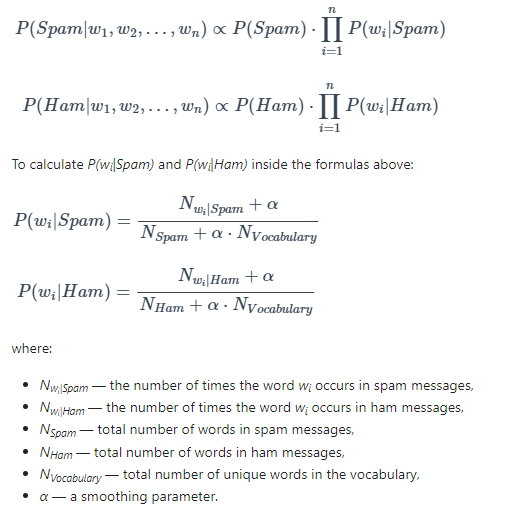

In [56]:
#P(Spam) and P(Ham)
training_set_clean['Label'].value_counts(normalize=True)

Label
ham     0.86541
spam    0.13459
Name: proportion, dtype: float64

In [57]:
p_spam = training_set_clean['Label'].value_counts(normalize=True).iloc[1]
p_ham = training_set_clean['Label'].value_counts(normalize=True).iloc[0]
print(p_spam)
print(p_ham)

0.13458950201884254
0.8654104979811574


In [58]:
# N_Spam
spam_mask = training_set_clean['Label'] == 'spam'
n_words_per_spam_message = training_set_clean[spam_mask]['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
ham_mask = training_set_clean['Label'] == 'ham'
n_words_per_ham_message = training_set_clean[ham_mask]['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

print(n_spam)
print(n_ham)
print(n_vocabulary)

15190
57237
7783


#### Calculating Parameters

The parameters will vary with every unique word in the training set. We will need to calculate them for all the unique words. The parameters will stay thereafter when the computer processes the testing set.

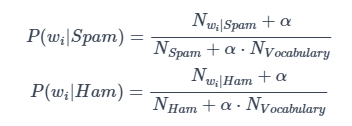

We will use the above equation to calculate the probability of any word in a spam message and non-spam message.

In [59]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

In [60]:
#Isolate Spam / Ham messages into two different dataframes
spam_set = training_set_clean[training_set_clean['Label']=='spam']
ham_set = training_set_clean[training_set_clean['Label']=='ham']

In [61]:
#Calculate P(w|Spam)
for word in vocabulary:
    n_word_spam = spam_set[word].sum()
    p_word_spam = (n_word_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_spam

In [62]:
#Calculate P(w|Ham)
for word in vocabulary:
    n_word_ham = ham_set[word].sum()
    p_word_ham = (n_word_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_ham

#### Classifying New Messages <a class='anchor' id='8'></a>

Now that we've calculated all the constants and parameters we need, we can start creating the spam filter.

Our spam filter function will:

Take in new message.
Calculate P(Spam) and P(Ham) for each word.
Then it will compare the two.

- If P(Spam) > P(Ham), then message will be classified as spam.
- If P(Ham) > P(Spam), then message will be classified as ham.
- If probabilities are equal, then algorithm will call on human help.

To calculate the Probability we will use the following equation:

P(Spam|word1,word2...) = P(Spam) * P(word1|Spam) * P(word2|Spam) *...

Note that some new messages will contain words that are not part of the vocabulary. Recall from the previous lesson that we simply ignore these words when we're calculating the probabilities.

In [63]:
def classify(message):

    message = re.sub(r'\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
        else:
            pass

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        else:
            pass

    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [64]:
message = 'WINNER!! This is the secret code to unlock the money: C3421.'
classify(message)

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [65]:
message = "Sounds good, Tom, then see u there"
classify(message)

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


#### Measuring the Spam Filter's Accuracy <a class='anchor' id='9'></a>

We will change the function to return labels for application to our test set.

In [66]:
def classify_test(message):

    message = re.sub(r'\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
        else:
            pass

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        else:
            pass
        
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [67]:
test_set['predicted'] = test_set['SMS'].apply(classify_test)
test_set.head(4)

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham


Now we can compare the label with predicted to see our accuracy.

In [68]:
correct = 0
total = 0
for label,filter in zip(test_set['Label'],test_set['predicted']):
    if label == filter:
        correct += 1
    total += 1
accuracy = round(100*(correct / total),2)
print(accuracy)

98.74


The accuracy is 98.74%.

#### Conclusion <a class='anchor' id='10'></a>

In this project, we built a spam filter function for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set, which is an excellent result. 

We've been able to demonstrate a few key concepts:

- Assign probabilities to events based on certain conditions by using conditional probability rules.
- Assign probabilities to events based on whether they are in relationship of statistical independence or not with other events.
- Assign probabilities to events based on prior knowledge by using Bayes' theorem.
- Create a spam filter for SMS messages using the multinomial Naive Bayes algorithm.

#### Additional <a class='anchor' id='11'></a>

##### Most Frequent Words in Spam

Let's look at the most frequent words that appear in Spam as an additional fun bonus!

In [69]:
import operator
from wordcloud import WordCloud, STOPWORDS

In [70]:
spam_sms = training_set[training_set['Label']=='spam']
ham_sms = training_set[training_set['Label']=='ham']

# Creating a dictionary of words from all spam messages with their frequencies
spam_dict = {}
for sms in spam_sms['SMS']:
    for word in sms:
        if word not in spam_dict:
            spam_dict[word]=0
        spam_dict[word]+=1

# Sorting the dictionary in descending order of word frequencies 
sorted_spam_dict = dict(sorted(spam_dict.items(), key=operator.itemgetter(1), reverse=True))

In [72]:
sorted_spam_dict

{'to': 546,
 'a': 307,
 'call': 289,
 'you': 255,
 'your': 211,
 'free': 175,
 'now': 169,
 '2': 165,
 'the': 157,
 'for': 153,
 'or': 147,
 'is': 136,
 'txt': 131,
 'u': 129,
 'ur': 116,
 'on': 112,
 'have': 111,
 '4': 104,
 'stop': 102,
 'from': 101,
 'and': 97,
 'mobile': 97,
 'text': 93,
 'claim': 90,
 '1': 90,
 'reply': 88,
 'with': 88,
 'www': 79,
 'of': 79,
 'prize': 76,
 't': 71,
 'this': 70,
 'in': 67,
 'our': 66,
 'only': 65,
 'get': 64,
 'are': 64,
 's': 63,
 'just': 63,
 'send': 62,
 'won': 61,
 'new': 61,
 'cash': 60,
 'no': 58,
 'nokia': 58,
 'uk': 57,
 '150p': 56,
 'win': 51,
 'i': 50,
 'tone': 50,
 'out': 49,
 'urgent': 47,
 'week': 46,
 'service': 45,
 'contact': 45,
 'com': 44,
 'msg': 43,
 '16': 43,
 'please': 43,
 'chat': 42,
 'guaranteed': 41,
 'be': 41,
 'c': 40,
 '50': 40,
 'per': 39,
 'who': 39,
 'we': 39,
 'customer': 39,
 'will': 38,
 '500': 37,
 '3': 37,
 'co': 37,
 'min': 36,
 'phone': 35,
 'been': 35,
 'by': 34,
 '18': 34,
 'cs': 34,
 'awarded': 32,
 'sms':

In [93]:
top = []
#Let's iterate through the dictionary and select for words with >20 count and length >4 characters. Hopefully this will help us screen through auxillary words (on, and, is, with, etc). Of course, we could be screening important words like "free" and "won" or "cash". 
for x,y in sorted_spam_dict.items():
    if y > 20 and len(x) > 4:
        top.append(x)
top

['mobile',
 'claim',
 'reply',
 'prize',
 'nokia',
 'urgent',
 'service',
 'contact',
 'please',
 'guaranteed',
 'customer',
 'phone',
 'awarded',
 'message',
 'ringtone',
 'video',
 'receive',
 '150ppm',
 'latest',
 'number',
 'every',
 'award',
 'holiday',
 'camera',
 'landline',
 'chance',
 'apply',
 'shows',
 'orange',
 'national',
 'valid',
 'selected',
 'offer']

In [94]:
len(top)

33

In [95]:
top_sorted_spam_dict = {}
#Create new dictionary and assign key-value pair (word:frequency)
for word in top:
    if word in sorted_spam_dict:
        top_sorted_spam_dict[word]=sorted_spam_dict[word] 

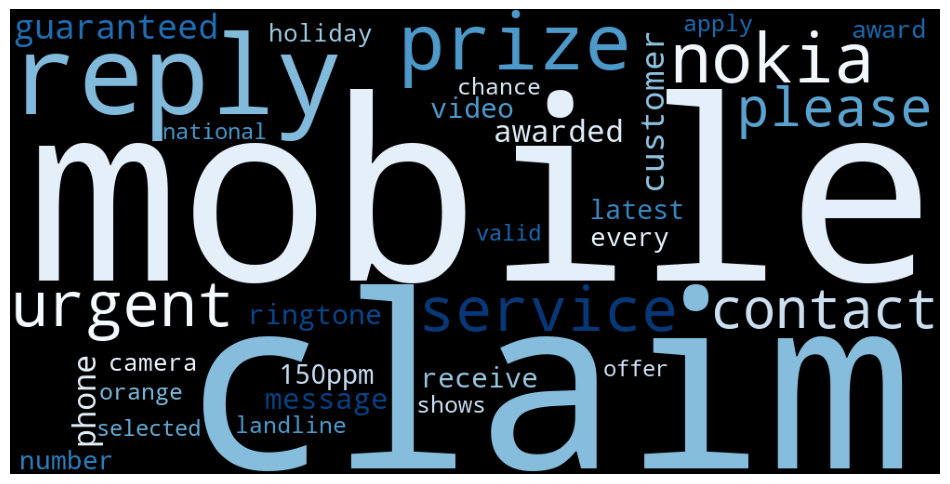

In [112]:
# Creatie word cloud
fig = plt.subplots(figsize=(12,10)) 
wordcloud = WordCloud(width=1000, height=500,
                      background_color='black', colormap='Blues',
                      random_state=1).generate_from_frequencies(top_sorted_spam_dict)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()